In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy import stats
from tabulate import tabulate
import seaborn as sns


### Loading Data

In [61]:
df=pd.read_csv('assessment_da25.csv')

In [64]:
df.head()

,Variant,Number of page views,GMV (in $),Number of add to cart,Clicks on media,Time on Page (sec),user_id,Conversion Rate
0,A,5,0.0,0,2,74,0,0.0
1,A,4,0.0,4,1,21,1,1.0
2,A,4,0.0,2,0,1,2,0.5
3,A,5,0.0,0,1,26,3,0.0
4,A,5,0.0,3,3,46,4,0.6


In [48]:
#check null value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Variant                2000 non-null   object 
 1   Number of page views   2000 non-null   int64  
 2   GMV (in $)             2000 non-null   float64
 3   Number of add to cart  2000 non-null   int64  
 4   Clicks on media        2000 non-null   int64  
 5   Time on Page (sec)     2000 non-null   int64  
 6   user_id                2000 non-null   int64  
 7   Conversion Rate        1988 non-null   float64
dtypes: float64(2), int64(5), object(1)
memory usage: 125.1+ KB


In [62]:
df.isnull().sum()

Variant                  0
Number of page views     0
GMV (in $)               0
Number of add to cart    0
Clicks on media          0
Time on Page (sec)       0
user_id                  0
dtype: int64

### Checking Population of A/B Variants

In [8]:
df['Variant'].value_counts()

Variant
A    1000
B    1000
Name: count, dtype: int64

### Ploting Different Metrics

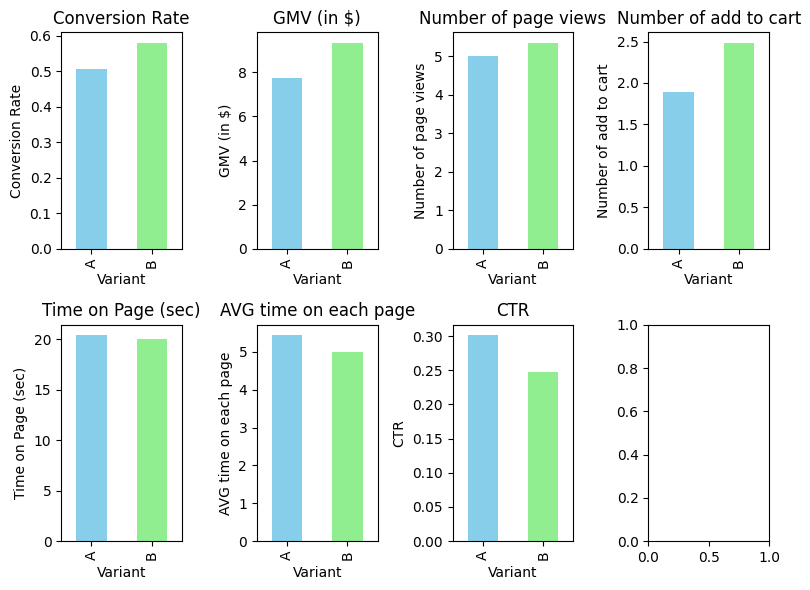


Quantitative Results:
╒═══════════════════════╤═══════════╤═══════════╤════════════════╕
│                       │         A │         B │   Difference % │
╞═══════════════════════╪═══════════╪═══════════╪════════════════╡
│ Conversion Rate       │  0.506522 │  0.58126  │       14.7552  │
├───────────────────────┼───────────┼───────────┼────────────────┤
│ GMV (in $)            │  7.72863  │  9.35502  │       21.0436  │
├───────────────────────┼───────────┼───────────┼────────────────┤
│ Number of page views  │  5.01005  │  5.35448  │        6.8748  │
├───────────────────────┼───────────┼───────────┼────────────────┤
│ Number of add to cart │  1.89347  │  2.4864   │       31.3149  │
├───────────────────────┼───────────┼───────────┼────────────────┤
│ Time on Page (sec)    │ 20.4332   │ 20.0665   │       -1.79463 │
├───────────────────────┼───────────┼───────────┼────────────────┤
│ AVG time on each page │  5.44511  │  5.00874  │       -8.01398 │
├───────────────────────┼───────────┼──

In [71]:
#Conversion Rate
df['Conversion Rate'] = df['Number of add to cart'] / df['Number of page views']
df['AVG time on each page'] = df['Time on Page (sec)'] / df['Number of page views']
df['CTR'] = (df['Clicks on media'] / df['Number of page views']) 
df.dropna(subset=['Conversion Rate'], inplace=True)

fig, axes = plt.subplots(2, 4, figsize=(8, 6))

metrics = ['Conversion Rate','GMV (in $)', 'Number of page views', 'Number of add to cart', 'Time on Page (sec)','AVG time on each page','CTR' ]
results = {}

for i, metric in enumerate(metrics):
    row = i // 4
    col = i % 4
    df.groupby('Variant')[metric].mean().plot(kind='bar', ax=axes[row, col], color = ['skyblue', 'lightgreen'])
    axes[row, col].set_title(metric)
    axes[row, col].set_xlabel('Variant')
    axes[row, col].set_ylabel(metric)
    results[metric] = df.groupby('Variant')[metric].mean()

plt.tight_layout()
plt.show()

# Display Result and column of Difference as Table
results_df = pd.DataFrame(results)
transposed_results_df = results_df.transpose()
transposed_results_df['Difference %']=((transposed_results_df['B']/transposed_results_df['A'])-1)*100
print("\nQuantitative Results:")
#print(transposed_results_df)
print(tabulate(transposed_results_df, headers='keys', tablefmt='fancy_grid'))


### Primary Metric and Distribution

#### Identifying Primary Mertic :
When experimenting with various layouts for a cooking website's product page, it's crucial to select a metric that reflects user interaction with the media. With the shift from a horizontal to a vertical media rail, we aim to observe how this alteration influences user engagement with the media content. The metric we can utilize to assess this impact is the conversion rate.

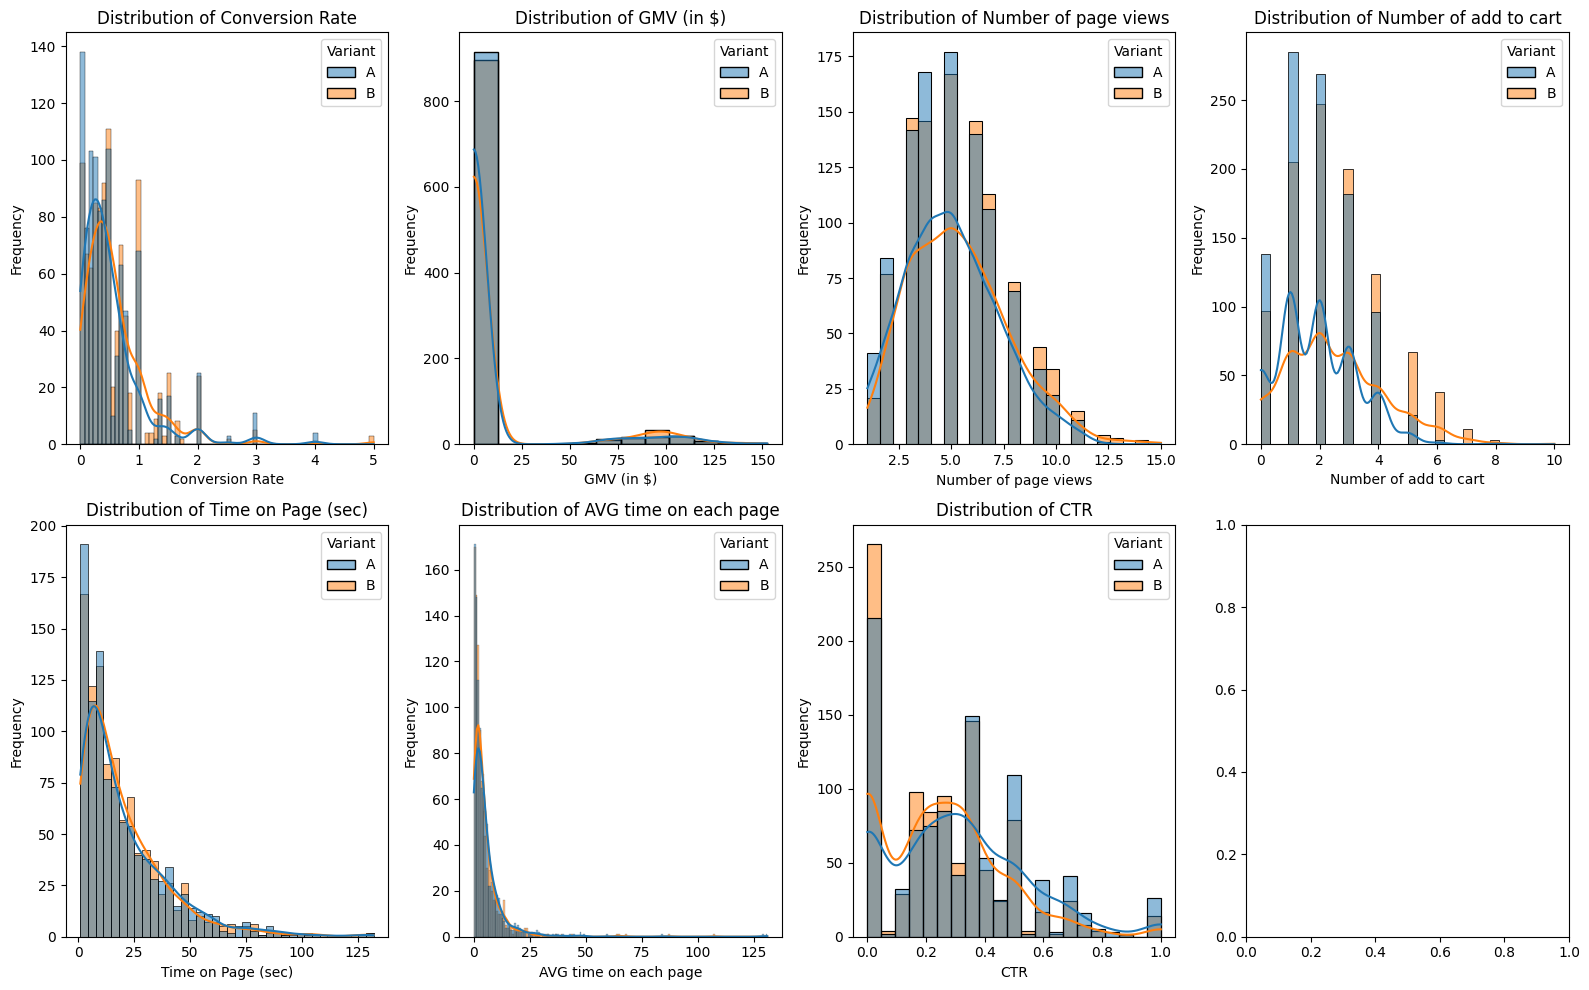

In [76]:
# Plot all metrics

fig, axes = plt.subplots(2, 4, figsize=(16, 10))

for i, metric in enumerate(metrics):
    row = i // 4
    col = i % 4
    sns.histplot(data=df, x=metric, hue='Variant', kde=True, ax=axes[row, col], alpha=0.5)
    axes[row, col].set_title('Distribution of ' + metric )
    axes[row, col].set_xlabel(metric)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Identifying H0 , H1

##### (H0): Changing the orientation of the media rail from horizontal to vertical does not have a significant impact on conversion rates
##### (H1): Changing the orientation of the media rail from horizontal to vertical does have a significant impact on conversion rates

### A/B Testing



In [86]:
primary_metric = 'Conversion Rate'

#The proportions_ztest function is typically used when comparing proportions or percentages between two groups.
#conversion rate can be considered a proportion. conversion rate typically refers to the proportion of users who take a specific action.

# Calculate the number of conversions and opportunities for each variant
conversions_A = df[df['Variant'] == 'A']['Number of add to cart'].sum()
opportunities_A = df[df['Variant'] == 'A']['Number of page views'].sum()

conversions_B = df[df['Variant'] == 'B']['Number of add to cart'].sum()
opportunities_B = df[df['Variant'] == 'B']['Number of page views'].sum()

conversion_rate_A = round(conversions_A / opportunities_A, 2)
conversion_rate_B = round(conversions_B / opportunities_B, 2)

# Perform Z-test for proportions
z_stat, p_value = proportions_ztest([conversions_A, conversions_B], 
                                     [opportunities_A, opportunities_B])

print("Z-statistic: {:.3f}".format(z_stat))
print("P-value: {:.3f}".format(p_value))

if p_value < alpha:
     print("The difference in Conversion Rate between variant A and variant B is statistically significant.")
else:
     print("There is no statistically significant difference in Conversion Rate between variant A and variant B.")

print("Conversion Rate for Variant A:", conversion_rate_A)
print("Conversion Rate for Variant B:", conversion_rate_B)


Z-statistic: -8.875
P-value: 0.000
The difference in Conversion Rate between variant A and variant B is statistically significant.
Conversion Rate for Variant A: 0.38
Conversion Rate for Variant B: 0.46


In [88]:


data_variant_a = df[df['Variant'] == 'A'][primary_metric]
data_variant_b = df[df['Variant'] == 'B'][primary_metric]

T_statistic, P_Value = stats.ttest_ind(data_variant_a.dropna(), data_variant_b.dropna(), equal_var=False)

alpha = 0.05

print("T-Statistic:{:.3f}".format(T_statistic) )
print("P-Value:{:.3f}" .format(P_Value))

# Check for statistical significance
if p_value < alpha:
    print("The difference in", primary_metric, "between variant A and variant B is statistically significant.")
else:
    print("There is no statistically significant difference in", primary_metric, "between variant A and variant B.")


T-Statistic:-3.009
P-Value:0.003
The difference in Conversion Rate between variant A and variant B is statistically significant.


### Test all metrics

Metric: Conversion Rate
T-Statistic:-3.009
P-Value:0.003
The difference in Conversion Rate between variant A and variant B is statistically significant.

Metric: GMV (in $)
T-Statistic:-1.298
P-Value:0.003
There is no statistically significant difference in GMV (in $) between variant A and variant B.

Metric: Number of page views
T-Statistic:-3.338
P-Value:0.003
The difference in Number of page views between variant A and variant B is statistically significant.

Metric: Number of add to cart
T-Statistic:-8.902
P-Value:0.003
The difference in Number of add to cart between variant A and variant B is statistically significant.

Metric: Time on Page (sec)
T-Statistic:0.413
P-Value:0.003
There is no statistically significant difference in Time on Page (sec) between variant A and variant B.

Metric: AVG time on each page
T-Statistic:1.171
P-Value:0.003
There is no statistically significant difference in AVG time on each page between variant A and variant B.

Metric: CTR
T-Statistic:5.378
P-V

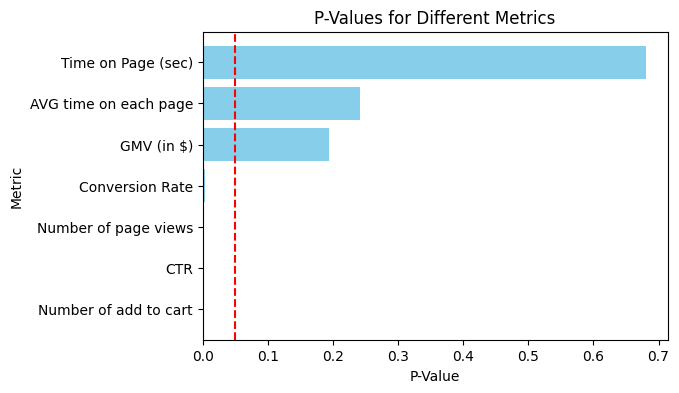

In [104]:
import scipy.stats as stats

alpha = 0.05
p_values = []
for metric in metrics:
    data_variant_a = df[df['Variant'] == 'A'][metric]
    data_variant_b = df[df['Variant'] == 'B'][metric]

    T_statistic, p_value = stats.ttest_ind(data_variant_a.dropna(), data_variant_b.dropna(), equal_var=False)
    p_values.append(round(p_value, 3))
    
    print("Metric:", metric)
    print("T-Statistic:{:.3f}".format(T_statistic) )
    print("P-Value:{:.3f}" .format(P_Value))
    

    # Check for statistical significance
    if p_value < alpha:
        print("The difference in", metric, "between variant A and variant B is statistically significant.")
    else:
        print("There is no statistically significant difference in", metric, "between variant A and variant B.")
    print()
    
p_values_df = pd.DataFrame({'Metric': metrics, 'P-Value': p_values})
p_values_df = p_values_df.sort_values(by='P-Value', ascending=True).reset_index(drop=True)
print(p_values_df)

# Plot different P_values
plt.figure(figsize=(6, 4))
plt.barh(p_values_df['Metric'], p_values_df['P-Value'], color='skyblue')
plt.axvline(x=alpha, color='red', linestyle='--', label='alpha')
plt.xlabel('P-Value')
plt.ylabel('Metric')
plt.title('P-Values for Different Metrics')
plt.show()

### For recommendation to company

In [111]:
# Perform one-tailed Z-test for proportions
z_stat, p_value = proportions_ztest([conversions_A, conversions_B], 
                                     [opportunities_A, opportunities_B],
                                     alternative='larger')  

print("Z-statistic: {:.3f}".format(z_stat))
print("P-value: {:.3f}".format(p_value))

alpha = 0.05

if p_value < alpha:
    print("Conversion Rate for Variant B is significantly greater than that of Variant A.")
else:
    print("Conversion Rate for Variant B is not significantly greater than that of Variant A.")

print("Conversion Rate for Variant A: {:.2%}".format(conversion_rate_A))
print("Conversion Rate for Variant B: {:.2%}".format(conversion_rate_B))


Z-statistic: -8.875
P-value: 1.000
Conversion Rate for Variant B is not significantly greater than that of Variant A.
Conversion Rate for Variant A: 38.00%
Conversion Rate for Variant B: 46.00%
